In [1]:
from scipy.special import expit
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator

class LogisticRegression(BaseEstimator):
    def __init__(self, alpha=0.05, lr=0.1, max_iter=1e3,
                 fit_intercept=True, batch_size = 128, delta_converged = 1e-2):
        self.batch_size = batch_size
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.delta_converged = delta_converged

    @staticmethod
    def _sigmoid(x):
        return expit(x)

    def _add_intercept(self, X):

        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1.)
        X_copy[:, :-1] = X

        return X_copy

    def fit(self, X, Y):
        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept: 
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()
        n_samples, n_features = X_copy.shape

        batch_split_mask = [x for x in range(self.batch_size, n_samples, self.batch_size)]
        weights = np.random.sample((n_features))
        num_steps = -1
        while (num_steps := num_steps + 1) < self.max_iter:
            
            X_step, y_step = shuffle(X_copy, Y)
            X_batches, y_batches = np.split(X_step, batch_split_mask), np.split(y_step, batch_split_mask)
            for X_batch, y_batch in zip(X_batches, y_batches):
                curr_batch_len = len(y_batch)
                
                if curr_batch_len != self.batch_size:
                    continue
                reg_weights = np.copy(weights)
                sigmoid_vector = self._sigmoid(X_batch @ weights)
                if self.fit_intercept:
                    reg_weights[-1] = 0
                gradient = (X_batch.T @ (sigmoid_vector - y_batch))/self.batch_size  + (2 * self.alpha) * reg_weights
                weights -= self.lr * gradient
                if (np.linalg.norm(gradient) < self.delta_converged):
                    self.weights = weights
                    return self
        
        self.weights = weights
        return self

    def predict(self, X):
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]
        y_pred = self._sigmoid(X_copy @ self.weights)
        y_pred[y_pred > 0.5] = 1.
        y_pred[y_pred <= 0.5] = 0.
        return y_pred[:, None]

    def predict_proba(self, X):

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]
        y_pred_proba = self._sigmoid(X_copy @ self.weights)
        return np.hstack([y_pred_proba, 1. - y_pred_proba])


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

In [3]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
model = LogisticRegression(fit_intercept = True)
model = model.fit(X_train, Y_train)

In [6]:
from sklearn.metrics import f1_score
f1_score(Y_test, model.predict(X_test))

0.9793103448275862

In [7]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]
models_lr_list = [LogisticRegression(lr = lr_) for lr_ in lrs]

In [8]:
f_1_score_list = []
for model, lr in zip(models_lr_list, lrs):
    model = model.fit(X_train, Y_train)
    score = f1_score(Y_test, model.predict(X_test))
    f_1_score_list.append(score)
    print("lr = " + str(lr) + ", f_1 score = " + str(score))

lr = 1e-05, f_1 score = 0.1176470588235294
lr = 0.0001, f_1 score = 0.2222222222222222
lr = 0.001, f_1 score = 0.9645390070921985
lr = 0.01, f_1 score = 0.9861111111111112
lr = 0.1, f_1 score = 0.9793103448275862
lr = 0.2, f_1 score = 0.9793103448275862
lr = 0.3, f_1 score = 0.9861111111111112
lr = 0.5, f_1 score = 0.9861111111111112
lr = 0.7, f_1 score = 0.9793103448275862
lr = 1, f_1 score = 0.9861111111111112
lr = 2, f_1 score = 0.9793103448275862
lr = 5, f_1 score = 0.896551724137931
lr = 10, f_1 score = 0.5401459854014597


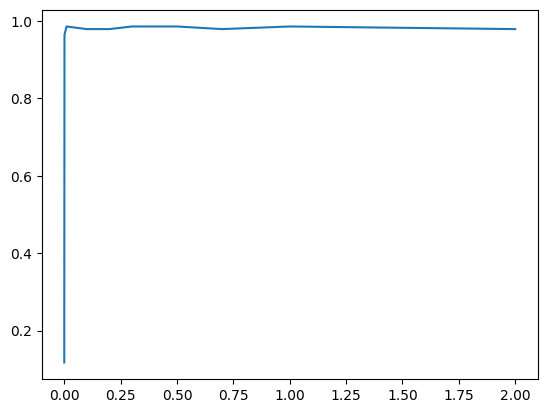

In [9]:
import matplotlib.pyplot as plt
plt.plot(lrs[:-2], f_1_score_list[:-2])
plt.show()

In [28]:
reg_coef = np.linspace(0, 0.02, 15)
optim_lr = lrs[np.argmax(f_1_score_list)]
models_reg_list = [LogisticRegression(lr = optim_lr, alpha = reg) for reg in reg_coef]

In [29]:
f_1_score_list_reg = []
for model, reg in zip(models_reg_list, reg_coef):
    model = model.fit(X_train, Y_train)
    score = f1_score(Y_test, model.predict(X_test))
    f_1_score_list_reg.append(score)
    print("reg = " + str(reg) + ", f_1 score = " + str(score))

reg = 0.0, f_1 score = 0.9859154929577465
reg = 0.0014285714285714286, f_1 score = 0.993006993006993
reg = 0.002857142857142857, f_1 score = 0.979020979020979
reg = 0.004285714285714286, f_1 score = 0.9861111111111112
reg = 0.005714285714285714, f_1 score = 0.9859154929577465
reg = 0.007142857142857143, f_1 score = 0.993006993006993
reg = 0.008571428571428572, f_1 score = 0.993006993006993
reg = 0.01, f_1 score = 0.9861111111111112
reg = 0.011428571428571429, f_1 score = 0.9861111111111112
reg = 0.012857142857142857, f_1 score = 0.993006993006993
reg = 0.014285714285714285, f_1 score = 0.9861111111111112
reg = 0.015714285714285715, f_1 score = 0.9861111111111112
reg = 0.017142857142857144, f_1 score = 0.9861111111111112
reg = 0.018571428571428572, f_1 score = 0.9861111111111112
reg = 0.02, f_1 score = 0.9861111111111112


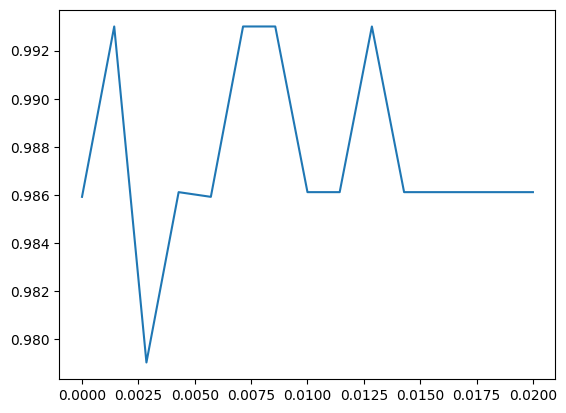

In [31]:
import matplotlib.pyplot as plt
plt.plot(reg_coef, f_1_score_list_reg)
plt.show()

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

models_reg_list = [LogisticRegression(lr = optim_lr, alpha = reg) for reg in reg_coef]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=42)

kf_scores_list = []
ss_scores_list = []

for model in models_reg_list:
    pipeline = make_pipeline(StandardScaler(), model)

    kf_score = cross_val_score(
        pipeline, X, Y, cv=kf, scoring='f1_macro')
    kf_scores_list.append(kf_score.mean())
    print(kf_score.mean())
    ss_score = cross_val_score(
        pipeline, X, Y, cv=ss, scoring='f1_macro')
    ss_scores_list.append(ss_score.mean())
    print(ss_score.mean())

0.966194601676517
0.9760993554344678
0.9718337617261683
0.9865464235089295
0.9696601866999147
0.9835227658901751
0.9717319854843531
0.9775714826877702
0.9715419356572703
0.9820181009833631
0.9696599440077168
0.9804386332513838
0.9754907630134177
0.9789921107600561
0.9734980271990397
0.9774874458532443
0.9715636757397211
0.980473923167503
0.9735321351895104
0.9789453945942543
0.9657307466412238
0.9804079675620926
0.9715176592926815
0.9774157811567601
0.975432378658358
0.9789153041844191
0.9676650981005424
0.9789265958068466
0.969679573997371
0.980473923167503


In [33]:
best_reg_kf, best_reg_ss = reg_coef[np.argmax(kf_scores_list)], reg_coef[np.argmax(ss_scores_list)]
print(best_reg_kf, best_reg_ss)

0.008571428571428572 0.0014285714285714286


In [34]:
best_model_kf, best_model_ss = LogisticRegression(lr = optim_lr, alpha = best_reg_kf), LogisticRegression(lr = optim_lr, alpha = best_reg_ss)
kf_pipeline, ss_pipeline = make_pipeline(StandardScaler(), best_model_kf), make_pipeline(StandardScaler(), best_model_ss)
kf_score_best = []
ss_score_best = []
for i in range(100):
    kf_score = cross_val_score(
        pipeline, X, Y, cv=kf, scoring='f1_macro')
    kf_score_best.append(kf_score.mean())
    ss_score = cross_val_score(
        pipeline, X, Y, cv=ss, scoring='f1_macro')
    ss_score_best.append(ss_score.mean())
    print(i, kf_score.mean(), ss_score.mean())

0 0.9695833078333631 0.9789692582606913
1 0.9734179027615293 0.9789692582606913
2 0.9733669890335512 0.9820305373615744
3 0.9695833078333631 0.9804859080948116
4 0.9695833078333631 0.9804859080948116
5 0.9695994495598607 0.9804859080948116
6 0.9695833078333631 0.9774407296874426
7 0.9676650981005424 0.9773980672335979
8 0.9715176592926815 0.9789692582606913
9 0.9657277234475637 0.9789265958068466
10 0.9676650981005424 0.9789692582606913
11 0.9676650981005424 0.9758821107043586
12 0.9714835513022108 0.9789692582606913
13 0.9695833078333631 0.9804859080948116
14 0.9714835513022108 0.9804620444283747
15 0.969679573997371 0.9774407296874426
16 0.9734179027615293 0.9789265958068466
17 0.9676650981005424 0.9804859080948116
18 0.9695833078333631 0.9789265958068466
19 0.9695833078333631 0.9789692582606913
20 0.9676650981005424 0.9789692582606913
21 0.9676650981005424 0.9789692582606913
22 0.9676650981005424 0.9789692582606913
23 0.9676650981005424 0.9789573795215629
24 0.9715176592926815 0.978

In [35]:
std_kf, std_ss = np.var(kf_score_best), np.var(ss_score_best)
print(std_kf, std_ss)

4.596169238791048e-06 1.871435424562375e-06


**Вывод:** У ShuffleSplit меньше дисперсия, чем у KFold. Скорее всего это из-за +- регулярной структуры разбиения: KFold гарантирует, что тестовые куски не пересекаются, в то время как ShuffleSplit может содержать частично в тесте те же данные, что и были на других итерациях. Тестирование на частично повторяющейся выборке даст меньшую дисперсию в отличие от полностью различных тестовых данных.